## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [18]:
import string
import os

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [19]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [20]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [21]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r',encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [22]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [23]:
tokens = sorted(set(text))
len(tokens)

83

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [24]:
# dict <index>:<char>
# Your great code here
index_token = dict(zip(range(len(tokens)), tokens))

# dict <char>:<index>
# Your great code here
token_index = dict(zip(tokens, range(len(tokens))))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [25]:
# Your code here
# almost similar to week0_10:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.lin = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.lin(out)
        return out, hidden

    def initial_state(self, batch_size):
        return Variable(torch.zeros(1, batch_size, self.num_units)).to(device)

In [26]:
# some necessary staff
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = int(len(arr) / batch_size_total)
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
          y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y # returning generator, cause we have no need to iterate it twice

def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

def train(net, train_text, val_text, epochs=100, show_epoch=10, batch_size=10,
          seq_length=50, lr=0.001, clip=5,
          lstm=False):

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loss_epoch, val_loss_epoch = list(), list()
    n_chars = len(tokens)
    for e in range(epochs):
        h = net.initial_state(batch_size)
        for x, y in get_batches(train_text, batch_size, seq_length):
            net.train()
            x = one_hot_encode(x, n_chars)
            inputs = torch.from_numpy(x).to(device)
            targets = torch.from_numpy(y).to(device)
            net.zero_grad()
            if lstm:
                h = tuple([each.data for each in h])
            else:
                h = h.detach()

            output, h = net(inputs, h)
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
        if e == 0 or (e+1) % show_epoch == 0:
            val_h = net.initial_state(batch_size)
            val_losses = []
            net.eval()
            for x, y in get_batches(val_text, batch_size, seq_length):
                x = one_hot_encode(x, n_chars)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                if lstm:
                    val_h = tuple([each.data for each in val_h])
                else:
                    val_h = val_h.detach()

                inputs, targets = x, y
                inputs, targets = inputs.to(device), targets.to(device)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                val_losses.append(val_loss.item())
                train_loss_epoch.append(loss.item())
                val_loss_epoch.append(np.mean(val_losses))
                print(f'Epoch {e + 1} of {epochs}: training loss: {train_loss_epoch[-1]:.6f}; validation loss: {val_loss_epoch[-1]:.6f}')
        elif lstm:
            print(f'Epoch {e + 1} of {epochs}')

    return train_loss_epoch, val_loss_epoch

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [27]:
# Your plot code here
# we will use it a little bit later
def plot_train_process(train_loss, val_loss, epoch_gap=1):
    fig, axes = plt.subplots(1, 1,figsize=(15,5))
    axes.set_title("Loss")
    axes.plot(train_loss, label='train')
    axes.plot(val_loss, label='test')
    axes.grid()
    axes.set_xlabel('n epoch * {}'.format(epoch_gap))
    axes.legend()
    axes.plot()

In [28]:
def predict(net, char, h=None, temperature=0.2, lstm=False):
        x = np.array([[token_index[char]]])
        x = one_hot_encode(x, len(tokens))
        inputs = torch.from_numpy(x).to(device)
        if lstm:
            h = tuple([each.data for each in h])
        else:
            h = h.detach()

        out, h = net(inputs, h)

        p = F.softmax(out/temperature, dim=1).data
        p = p.cpu().numpy().squeeze()
        char = np.random.choice(len(tokens), p=p/p.sum())
        return index_token[char], h

def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0, lstm=False):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    char_rnn.to(device)
    char_rnn.eval()

    chars_generated = [ch for ch in seed_phrase]
    h = char_rnn.initial_state(1)
    
    #feed the seed phrase, if any
    for ch in seed_phrase:
        char, h = predict(char_rnn, ch, h, temperature, lstm=lstm)
    
    #start generating
    chars_generated.append(char)
    while len(chars_generated) < max_length:
        char, h = predict(char_rnn, chars_generated[-1], h, temperature, lstm)
        chars_generated.append(char)
        
    return ''.join(chars_generated)

In [29]:
encoded = np.array([token_index[ch] for ch in text])
split_index = int(len(encoded)*0.9)
encoded_text_train, encoded_text_val = encoded[:split_index], encoded[split_index:]

In [30]:
# finally, let's train it

n_epoch = 100
epoch_gap = 10

net = CharRNNLoop(len(tokens), rnn_num_units=256,emb_size=83).to(device)
train_loss, val_loss = train(net, encoded_text_train, encoded_text_val,
                             epochs=n_epoch, show_epoch=epoch_gap,
                             batch_size=100, seq_length=100)

Epoch 1 of 100: training loss: 3.354557; validation loss: 3.377527
Epoch 10 of 100: training loss: 3.076030; validation loss: 3.105921
Epoch 20 of 100: training loss: 2.624316; validation loss: 2.670430
Epoch 30 of 100: training loss: 2.503642; validation loss: 2.554001
Epoch 40 of 100: training loss: 2.379858; validation loss: 2.428682
Epoch 50 of 100: training loss: 2.318217; validation loss: 2.391557
Epoch 60 of 100: training loss: 2.256143; validation loss: 2.341220
Epoch 70 of 100: training loss: 2.199328; validation loss: 2.306563
Epoch 80 of 100: training loss: 2.156571; validation loss: 2.285008
Epoch 90 of 100: training loss: 2.115842; validation loss: 2.264848
Epoch 100 of 100: training loss: 2.053368; validation loss: 2.252438


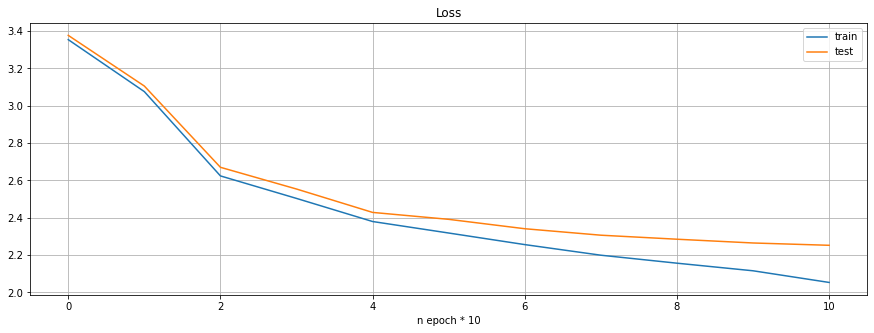

In [31]:
plot_train_process(train_loss, val_loss, epoch_gap)

In [32]:
# An example of generated text.
print(generate_sample(net, seed_phrase='довольно ', max_length=500, temperature=0.2))

довольно меня,
в сердце весны она доло



xxxvi

на приводний сердце ей него
в сердце свет онегин оне
не востеренный страстили
собразновой не своей
и молов и вере сторен,
и страсти в сердце головой,
и в сердце нене сверенье



xxii

ена приветним она и тать,
уж велет перел и постели
старой постолит своей свот
преденней сердце не востенье,
и все деле не все далой
постали с нем оне и слада
и все деленный приводать,
не страстит меня старина,
в сердце в сердце головой,
и в сердце серец неменей,
и в 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [33]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, emb_size=38, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2, dropout=0.5)
        self.lin = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.num_units)
        out = self.lin(out)
        return out, hidden

    def initial_state(self, batch_size):
        return (Variable(torch.zeros(2, batch_size, self.num_units)).to(device),
                Variable(torch.zeros(2, batch_size, self.num_units)).to(device))

Plot the loss function of the number of epochs. Does the final loss become better?

In [34]:
# Your beautiful code here

n_epoch = 100
epoch_gap = 10

net = CharLSTMLoop(len(tokens), rnn_num_units=512, emb_size=83).to(device)
train_loss, val_loss = train(net, encoded_text_train, encoded_text_val,
                             epochs=n_epoch, show_epoch=epoch_gap,
                             batch_size=100, seq_length=100, lstm=True)

Epoch 1 of 100: training loss: 3.389557; validation loss: 3.425460
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100: training loss: 3.268483; validation loss: 3.306181
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100: training loss: 2.629158; validation loss: 2.689316
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100: training loss: 2.429416; validation loss: 2.473901
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100: training loss: 2.288752; validation loss: 2.334057
Epoch 41 of 100
Epoch 42 of 100
Epoch 43 of 100
Epoch 44 of 100
Epoch 45 of 100
Epoch 46 of 100
Epoch 47 of 1

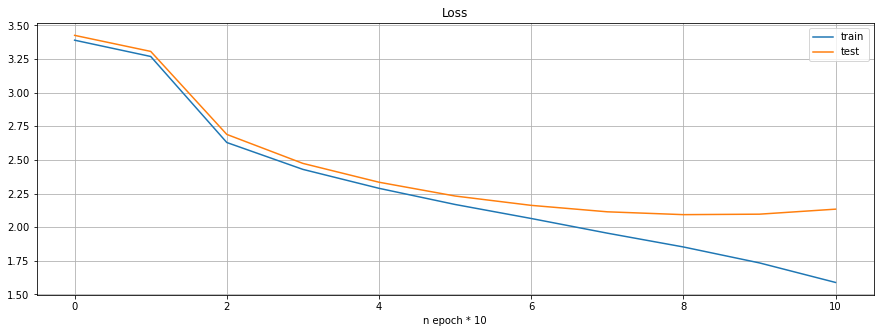

In [35]:
plot_train_process(train_loss, val_loss, epoch_gap)

In [36]:
# An example of generated text.
print(generate_sample(net, seed_phrase='довольно ', max_length=500, temperature=0.2, lstm=True))

довольно слевать сона сосед.



xxxiii

но вы, как судит в облодать,
и в том сердце последний мой,
и слов и переста и встрети,
и в том уж он весел весть
и на сторонных скорей взор,
когда ж нам друг мое в стох деви,
и скучный мой и старины
всё благоразные странной
с полемой с ней и потом всех,
и слез в пере в тем простился в нем.



xxxiii

когда ж начего там соседа
поэта покоронный строги,
в семенной в слезки солоненье,
и всё благослива в столом
не полно посленник порой
не отворилась не постели



Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [37]:
# Text generation with different temperature values here

for temp in [0.1, 0.2, 0.3, 0.5, 1.0, 2.0]:
    print('============= Current temp: {} ============='.format(temp))
    print(generate_sample(net, max_length=500, seed_phrase='прощай, онегин, мне пора ', temperature=temp, lstm=True))
    print()

============= Current temp: 0.1 =============
прощай, онегин, мне пора мне скоро,
и сердце блистая моей,
как был не всё верно томной
в своей солень в поле полены
и сталины страсти и полкой,
и сталы старинных долгой,
не простить ее последной
с ней негой скоре в постеленье
в семей столон и своей души,
и в самом делит и с ней свет.



xxxii

но так не сталал и с нем дале,
и в саду скучно и свой дель
и не все весто в полной лет
и в самум сторонных страсти,
и в следк перед и в сем перед,
и в следким солецы сторонный,
в семей светел ее порока
и с

============= Current temp: 0.2 =============
прощай, онегин, мне пора меня,
покойный старинных души.



xxxii

но вы, красавица в ней своей,
и сердце было одежать
и полно и того ж отка
и сталость не постоли поле



xxxiii

как он онегин сколовой,
подруг на страхом она вере
и снова на стороных душкой,
и следким молодых соседы
и слад неверный и поэт,
и страх не время по свете.



xxxviii

и вот полуд в скоре страшил
и что ж и так е онегин страни
с п

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [38]:
# Saving and loading code here

torch.save(net.state_dict(), './model.pt')
loaded_model = CharLSTMLoop(len(tokens), rnn_num_units=512, emb_size=83).to(device)
loaded_model.load_state_dict(torch.load('./model.pt'))
loaded_model.eval()
print(generate_sample(loaded_model, max_length=500, lstm=True, seed_phrase='спелое '))

спелое блидот.



xxviii

и рачно толка тани друга,
печально ине вослидьяет
расскам сумроши блещет нет
как булочань в полев коскем,
пой какой нестибя сегевий;
пройзут хотоф другь с изукой.



xiii

я сначин, тогу, мянять своей
свитались мокло поролка.
кого-на предтаму засять,
заачался с? куковь небравдо,
его всех толея дверец.



xlix

ханьчал сж ей утпа по однам,
онегин слоза в охляжает,
напясный верний ленский ром
ек пришуй, что таа, как на шум
очин пуйку шумно они.
но ужели блиго: простой,
ну


#### Итоговое сравнение

LSTM показало более вразумительные результаты, особенно на английском языке.
Великий и могучий так просто, видимо, не даётся.
У LSTM можно найти значительно больше настоящих слов, чем у ванильной версии.

Тем не менее, ванильная версия смогла показать неплохой результат
после обучения на произведении Война и Мир:

_пусть князя андрея в пристовной солдаты, как будто она она не уже простенное дело, как будто он положила она принила князь андрей вышел в комнате как бы все повел на него последния к своей комнату с такими своем обезать с тем же не понимаю, что он половения и подумал в колоно она обратилась к себе, что на все это простовой командир знал, что она застояла в своей заметив на коготом, очень хорошо и подороволись с таким голово в комнате от принят его в глаза и от толосо слово его надо было над себя_

Таким же образом обученная LSTM тоже показала хороший результат, но
ванильная версия, можно сказать, меня удивила.

Ещё я порадовался, что у меня хорошая видеокарта, вычисления не занимали больше 5 минут.
Коллеги говорили, что LSTM на CPU обучалась почти час.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)